# Predicting Churn using Pyspark

# Mini Sparkify Event Data for Initial Exploration

### Import libraries from PySpark

#### Please run below if you haven't import "pyspark" module on local environment:
#### !pip install pyspark

In [1]:
# Spark SQL
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, desc, udf, col, sort_array, asc, avg, lit, max, min, countDistinct
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# Spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Python basic
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Create a Spark session

In [2]:
# Download java first# Create a SparkSession with the application name "sparkify".
# SparkSession is the entry point for interacting with the Spark cluster.
# It requires Java Runtime Environment (JRE) to run, as Spark is built using Scala and Java.
spark = SparkSession \
.builder \
.appName("sparkify") \
.getOrCreate() 

### Load raw data

In [3]:
df = spark.read.json('data/mini_sparkify_event_data.json')

In [10]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [11]:
print('Total activity records:', df.count())
print('Total columns:', len(df.columns))

Total activity records: 286500
Total columns: 18


In [12]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Description for each column:
- **Artist**: Composer or artist of the song.
- **Auth**: Login status of the user.
- **firstName**: First name of the user.
- **gender**: Gender of the user.
- **ItemInSession**: Operation sequence number of this session, ordered from small to large based on time.
- **lastName**: Surname or last name of the user.
- **length**: Length of the song in seconds.
- **Level**: Indicates whether the user is a paid user.
- **location**: User's location.
- **method**: HTTP method used to access web pages (e.g., PUT or GET).
- **page**: Type of page or action being performed.
- **registration**: Timestamp representing the user's registration point in time.
- **sessionId**: Session ID used to identify a single login session.
- **song**: Name of the song being played or interacted with.
- **status**: HTTP page return code (e.g., 200, 307, 404).
- **ts**: Timestamp of the log entry.
- **UserAgent**: Information about the client's browser or user agent.
- **UserId**: Unique identifier for the user.




In [26]:
df.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



### Clean data

In [4]:
# Exclude "Guest" user
df = df.filter(df['userId']!='')

In [5]:
# Extract Cancelled User and Logged in user
df_clean = df.filter((col('auth') == 'Cancelled') | (col('auth') == 'Logged In'))

In [311]:
# check missing or invalid data
missing_info = []

for column in df_clean.columns:
    missing_count = df_clean.filter(col(column).isNull() | isnan(col(column)) | (col(column) == "")).count()
    total_count = df_clean.count()
    missing_percentage = (missing_count / total_count) * 100
    missing_info.append((column, missing_count, missing_percentage))

print('Missing values count and percentage per column:')
for column, count, percentage in missing_info:
    print(f'Column {column}: Missing Count: {count}, Missing Percentage: {percentage:.2f}%')

Missing values count and percentage per column:
Column artist: Missing Count: 95128, Missing Percentage: 18.02%
Column auth: Missing Count: 0, Missing Percentage: 0.00%
Column firstName: Missing Count: 0, Missing Percentage: 0.00%
Column gender: Missing Count: 0, Missing Percentage: 0.00%
Column itemInSession: Missing Count: 0, Missing Percentage: 0.00%
Column lastName: Missing Count: 0, Missing Percentage: 0.00%
Column length: Missing Count: 95128, Missing Percentage: 18.02%
Column level: Missing Count: 0, Missing Percentage: 0.00%
Column location: Missing Count: 0, Missing Percentage: 0.00%
Column method: Missing Count: 0, Missing Percentage: 0.00%
Column page: Missing Count: 0, Missing Percentage: 0.00%
Column registration: Missing Count: 0, Missing Percentage: 0.00%
Column sessionId: Missing Count: 0, Missing Percentage: 0.00%
Column song: Missing Count: 95129, Missing Percentage: 18.02%
Column status: Missing Count: 0, Missing Percentage: 0.00%
Column ts: Missing Count: 0, Missing

0 missing data (`UserId` and `SessionId`)

Please be aware that the 'artist' and 'songs' columns have more missing values, accounting for about 20% of rows. This is due to the nature of the records, which involve actions such as logging into the service and accessing the homepage.

## Exploratory Data Analysis

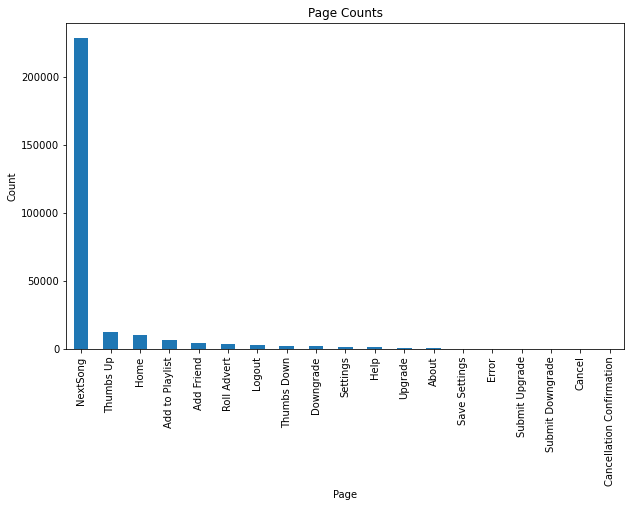

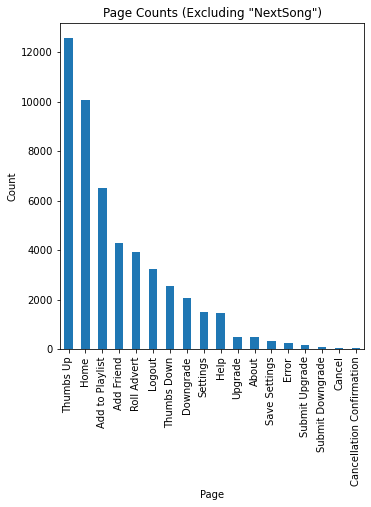

In [22]:
# `page` column
pandas_df = df_clean.select("page").toPandas()
label_counts = pandas_df['page'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Page')
plt.ylabel('Count')
plt.title('Page Counts')

# Filter out data without the "NextSong" label
filtered_df = df_clean.filter(df_clean.page != "NextSong")

# Convert DataFrame to a Pandas DataFrame
pandas_df = filtered_df.select("page").toPandas()

# Calculate the count of each label
label_counts = pandas_df['page'].value_counts()

# Create a bar chart to display the counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar')
plt.xlabel('Page')
plt.ylabel('Count')
plt.title('Page Counts (Excluding "NextSong")')

# Show the charts
plt.show()

The `page` variable shows the interaction information between the user and the spackify music app, where nextsongs can be used to calculate the number of songs the user listens to, thumbs up, thumbs down and other behaviors have obvious emotional colors, which are closely related to the user churn rate intuitively.

## Feature Engineering

In [6]:
# Create outcome column named "cancel"
df_clean = df_clean.withColumn('cancel', when(df_clean['auth'] == 'Cancelled', 1).otherwise(0).cast(IntegerType()))

In [7]:
# Convert gender to 1/0. 1 = male
male = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
df_clean = df_clean.withColumn('Male', male('gender'))

In [12]:
# Calculate user age since registration
df_clean = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))
df_clean = df_clean.withColumn('date_register', F.to_date(F.from_unixtime(col('registration')/lit(1000))))
df_clean = df_clean.withColumn('user_age', F.datediff(col('date'), col('date_register')))

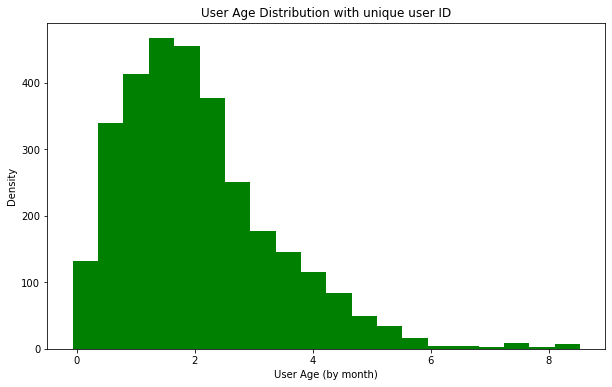

In [25]:
# Calculate distinct user ages
distinct_user_ages = df_clean.select("userId", "user_age").distinct()

# Divide user ages by 30
distinct_user_ages = distinct_user_ages.withColumn("user_age", distinct_user_ages["user_age"] / 30)

# Convert to Pandas DataFrame
pandas_df = distinct_user_ages.toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
pandas_df['user_age'].plot(kind='hist', bins=20, color='g')  # Adjust the number of bins as needed
plt.xlabel('User Age (by month)')
plt.ylabel('Density')
plt.title('User Age Distribution with unique user ID')
plt.show()

### Feature Generation from 'page' column

In [35]:
df_clean.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [27]:
# Create `Thumbs Down` feature which means negative feedback from user
Thumbs_Down = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())
df_clean = df_clean.withColumn('Thumbs_Down', Thumbs_Down('page'))

In [28]:
# Create `songs` feature to calculate number of songs from users
NextSong = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df_clean = df_clean.withColumn('songs', NextSong('page'))

In [29]:
# Create `downgrades` to show if the user ever downgraded
downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_clean = df_clean.withColumn('downgraded', downgrade('page'))

In [30]:
# Create `paid` to show if the user ever be 'paid' user
paid = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_clean = df_clean.withColumn('paid', paid('level'))

### Spark SQL

Convert raw event data into useful data which can be used to build prediction model

In [31]:
# user information
df_clean.createOrReplaceTempView("df_clean_temp")
users = spark.sql("""
    SELECT
        userId AS userId,
        male AS gender,
        MAX(user_age) AS user_age,
        MAX(paid) AS paid,
        MAX(downgraded) AS downgraded,
        MAX(cancel) AS canceled
    FROM
        df_clean_temp
    GROUP BY
        userId, male, date_register
""")

23/09/05 15:48:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [32]:
# Interaction information by user and session
df_clean.createOrReplaceTempView("df_clean_temp")
interaction = spark.sql("""
    SELECT
        userId AS userId,
        sessionId,
        MIN(date) AS start_date,
        MAX(date) AS end_date,
        SUM(Thumbs_Down) AS Thumbs_Down,
        SUM(songs) AS songs_num,
        COUNT(DISTINCT artist) AS artists_num
    FROM
        df_clean_temp
    GROUP BY
        userId, sessionId
""")

interaction.take(1)

[Row(userId='101', sessionId=635, start_date=datetime.date(2018, 10, 9), end_date=datetime.date(2018, 10, 11), Thumbs_Down=8, songs_num=708, artists_num=587)]

In [33]:
# Interaction infomration by user
interaction.createOrReplaceTempView("measures_temp")
interaction_user = spark.sql("""
    SELECT
        userId AS userId,
        COUNT(sessionId) AS total_session,
        AVG(Thumbs_Down) AS avg_Thumbs_Down,
        AVG(songs_num) AS avg_songs,
        AVG(artists_num) AS avg_artists_num,
        AVG(session_gap) AS avg_session_gap
    FROM (
        SELECT
            *,
            LAG(end_date) OVER (PARTITION BY userId ORDER BY start_date) AS prev_end_date,
            DATEDIFF(start_date, LAG(end_date) OVER (PARTITION BY userId ORDER BY start_date)) AS session_gap
        FROM
            measures_temp
    ) AS temp
    GROUP BY
        userId
""")


In [34]:
df_model = users.join(interaction_user, on = 'userId')

In [35]:
print(df_model.toPandas().shape)

(225, 11)


## Modeling

In [36]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- user_age: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- canceled: integer (nullable = true)
 |-- total_session: long (nullable = false)
 |-- avg_Thumbs_Down: double (nullable = true)
 |-- avg_songs: double (nullable = true)
 |-- avg_artists_num: double (nullable = true)
 |-- avg_session_gap: double (nullable = true)



### Correlation

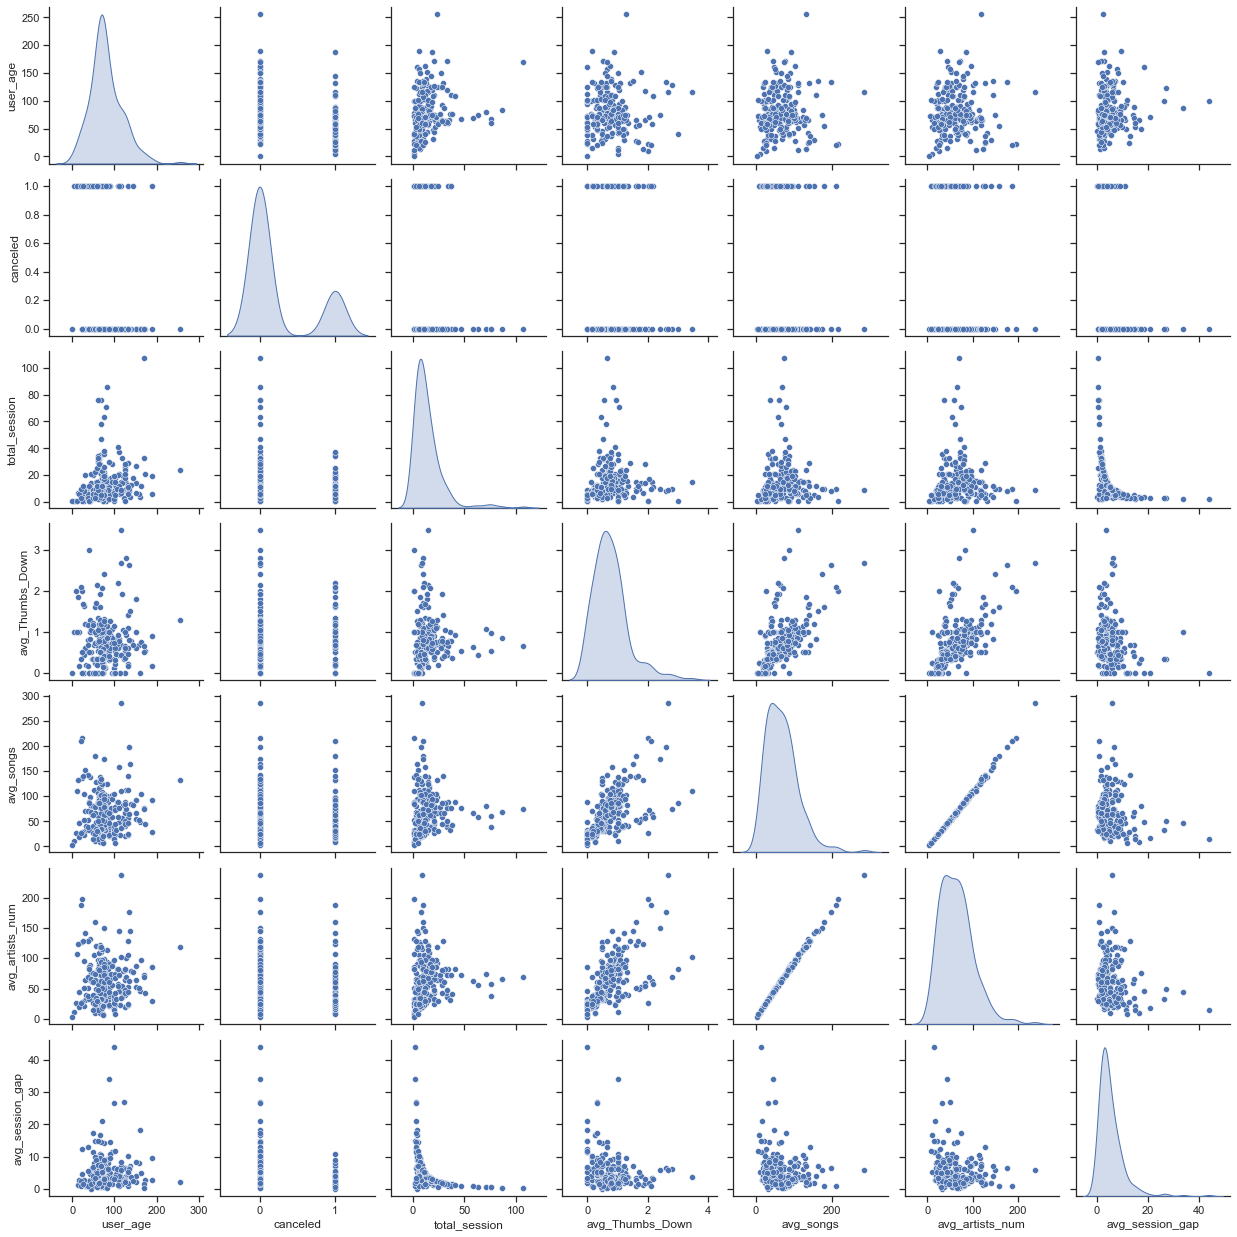

<Figure size 864x864 with 0 Axes>

In [59]:
cols_to_exclude = ['userID', 'gender', 'paid', 'downgraded']
cols_to_include = [col for col in df_model.columns if col not in cols_to_exclude]
df_model_subset = df_model.select(cols_to_include)

sns.set(style="ticks")
sns.pairplot(df_model_subset.toPandas(), diag_kind="kde")  # 将DataFrame转换为Pandas DataFrame
plt.figure(figsize=(12, 12))
plt.show()

### Logistic regression

In [37]:
# Assemble Features
assembler = VectorAssembler(inputCols=['gender','user_age','paid',\
                                       'downgraded','total_session',\
                                      'avg_Thumbs_Down','avg_artists_num','avg_session_gap','avg_songs'],\
                            outputCol='raw_features',handleInvalid = 'skip')
# ML pipeline
scaler = MinMaxScaler(inputCol="raw_features", outputCol="features")
preprocess_stages = [assembler, scaler]

rf = RandomForestClassifier(labelCol="canceled", featuresCol="features")
lr = LogisticRegression(labelCol="canceled", featuresCol="features")

pipeline = Pipeline(stages=[*preprocess_stages, lr])

train_data, test_data = df_model.randomSplit([0.7, 0.3], seed=42)

param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="canceled", metricName="areaUnderROC")

cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5,
                           seed=42)

model = cross_val.fit(train_data)
# Evaluate
test_results = model.transform(test_data)
area_under_roc = evaluator.evaluate(test_results)


best_model = model.bestModel
best_lr_model = best_model.stages[-1] 
best_reg_param = best_lr_model.getOrDefault("regParam")

print(f"Best regParam: {best_reg_param}")
print(f"Area Under ROC: {area_under_roc}")

23/09/05 15:49:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Best regParam: 0.01
Area Under ROC: 0.8364418938307031


### Random Forest

In [38]:
# ML pipeline
pipeline = Pipeline(stages=[*preprocess_stages, rf])

train_data, test_data = df_model.randomSplit([0.7, 0.3], seed=42)

param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="canceled", metricName="areaUnderROC")

cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5,
                           seed=42)

rf_model = cross_val.fit(train_data)

# evaluate
test_results = rf_model.transform(test_data)
area_under_roc = evaluator.evaluate(test_results)

In [39]:
best_model = rf_model.bestModel
best_rf_model = best_model.stages[-1]
best_rf_param = best_rf_model.getOrDefault("maxDepth")

print(f"Best maxDepth: {best_rf_param}")

print(f"Area Under ROC: {area_under_roc}")

Best maxDepth: 10
Area Under ROC: 0.8149210903873744


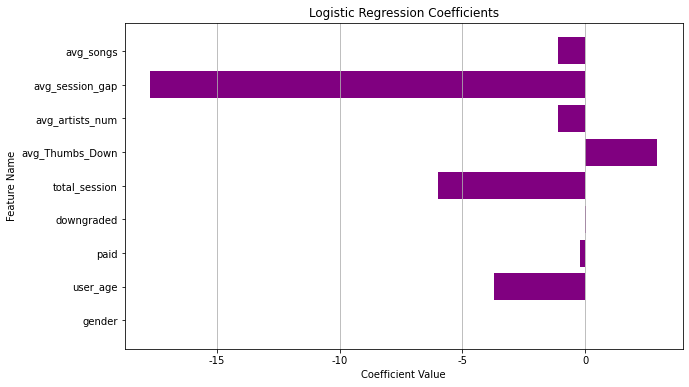

In [56]:
# Extract feature names from the original data

assembler = VectorAssembler(inputCols=['gender','user_age','paid',\
                                       'downgraded','total_session',\
                                      'avg_Thumbs_Down','avg_artists_num','avg_session_gap','avg_songs'],\
                            outputCol='raw_features',handleInvalid = 'skip')

data = assembler.transform(df_model)
dict_feats = data.schema['raw_features'].metadata['ml_attr']['attrs']['numeric']
list_feats = np.array([x['name'] for x in dict_feats])
# Get coefficients
lr_corr = model.bestModel.stages[-1].coefficients

plt.figure(figsize=(10, 6))
plt.barh(list_feats, lr_corr, color = 'purple')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Logistic Regression Coefficients')
plt.grid(axis='x')
plt.show()